In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lcc-fasd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F724551%2F1259264%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T144516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D741e0826fbda4f60adc2c784b2b17ce6c402a9ad04bc567699eb9ee4e39aef773fe57404f3c35a41e1f0eafa7e1b59f812ccc1e1766a284fd78bc8712c518db5890bafe4b435beb696de2338f695f98829a28a119eae01717723bc51bdcab2caf28650fc29f6451fda28c0b23c447a60039fc85f26b8813e3cc48e845bdd9e92785af5a920e35ba14ece7cc8645936e280b7afb0410e2d4b20de6307878eca6b0f95f3573e3f70df98363014e57c4dc92ad41555c0a64e5160d80af81f5e98a156779d3fc913a170b0328f464b2dd3fc9f08b5d46ec999c0214d7bd6bd9fc20c51b13abfd56e2131bbe553af1a7980eff4df9405f932e800c2b537547e21788e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5196000412 bytes downloaded
Downloaded and uncompressed: lcc-fasd
Data source import complete.


In [ ]:
!cp -r /kaggle /content/drive/MyDrive

# New Section

In [1]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import csv
import time

# Define paths to the dataset directories
train_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training'
dev_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_development'
test_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation'

# Load the datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Adjust based on your model's input size
    batch_size=32,
    label_mode='binary'  # Use 'categorical' for binary classification with softmax
)

dev_dataset = image_dataset_from_directory(
    dev_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)


def write_into_csv(model_params):
    #add extra info into end of model info in csv file
    x = 0
    with open(csv_file, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write top-level key-value pairs
        for key, value in model_params.items():
            if x == 0:
              writer.writerow([key, value])
              x+=1
            elif not isinstance(value, dict):  # Check if value is not a dictionary
                writer.writerow([key, value])
            else:  # Handle nested dictionary (data_augmentation)
                for inner_key, inner_value in value.items():
                    writer.writerow([key + '/' + inner_key, inner_value])


model_number = int(input("enter your last model number: "))
csv_file = 'output.csv'
model_params = {
    "epochs": 7,
    "callbacks": {
        "EarlyStopping": {"monitor": "val_loss", "patience": 2},
        "ModelCheckpoint": {"filepath": "model_checkpoint.keras", "save_best_only": True, "monitor": "val_loss", "verbose": 1},
        "CSVLogger":{"filename":csv_file,"separator":",","append":"True"}
    }
}

callbacks = [
    tf.keras.callbacks.EarlyStopping(**model_params['callbacks']['EarlyStopping']),
    tf.keras.callbacks.ModelCheckpoint(**model_params['callbacks']['ModelCheckpoint']),
    # tf.keras.callbacks.ReduceLROnPlateau(**model_params['callbacks']['ReduceLROnPlateau']),
    # tf.keras.callbacks.LearningRateScheduler(**model_params['callbacks']['LearningRateScheduler']),
    tf.keras.callbacks.CSVLogger(**model_params['callbacks']['CSVLogger']),
    # tf.keras.callbacks.TerminateOnNaN()
]
write_into_csv({' ':' ','model number':model_number})


Found 8299 files belonging to 2 classes.
Found 2948 files belonging to 2 classes.
Found 7580 files belonging to 2 classes.
enter your last model number: 1


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load a pre-trained model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Specify the number of layers to unfreeze from the end
num_layers_to_unfreeze = 10

# Unfreeze the last `num_layers_to_unfreeze` layers
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='softmax')(x)  # Binary classification with softmax

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model.summary()

In [5]:
start_time = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=model_params['epochs'],
    validation_data=dev_dataset,
    callbacks=callbacks,
    # verbose = 1,
    # shuffle = True,


)
end_time = time.time()
elapsed_time = end_time - start_time


Epoch 1/7
260/260 [==============================] - 2127s 8s/step - loss: 0.1798 - accuracy: 0.8526 - val_loss: 0.2990 - val_accuracy: 0.8626
Epoch 2/7
260/260 [==============================] - 135s 509ms/step - loss: 0.0555 - accuracy: 0.8526 - val_loss: 0.2330 - val_accuracy: 0.8626
Epoch 3/7
260/260 [==============================] - 132s 495ms/step - loss: 0.0329 - accuracy: 0.8526 - val_loss: 0.2282 - val_accuracy: 0.8626
Epoch 4/7
260/260 [==============================] - 129s 485ms/step - loss: 0.0162 - accuracy: 0.8526 - val_loss: 0.3317 - val_accuracy: 0.8626
Epoch 5/7
260/260 [==============================] - 130s 484ms/step - loss: 0.0156 - accuracy: 0.8526 - val_loss: 0.2938 - val_accuracy: 0.8626


In [10]:
model.save_weights('/content/drive/MyDrive/deep_learning_1.h5')

best Test accuracy: 0.8626187443733215 ,best test loss :0.2282092273235321 


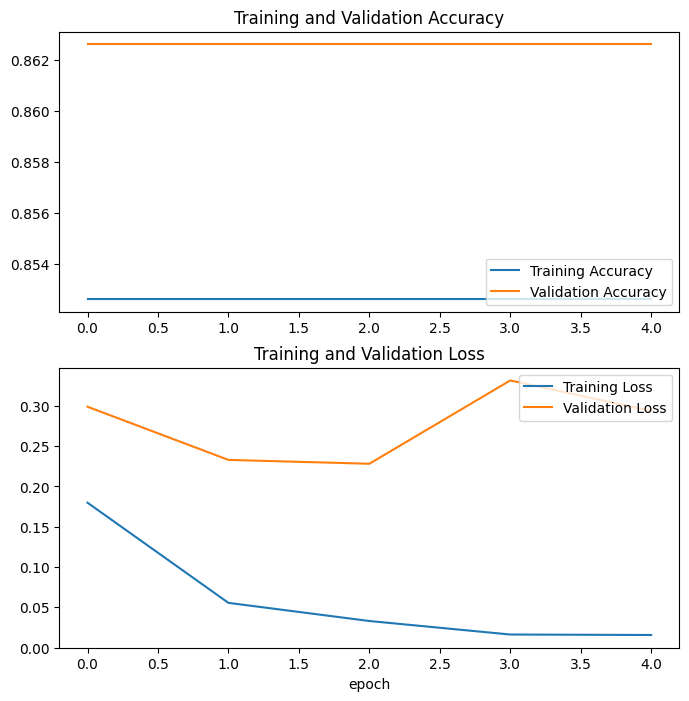

237/237 [==============================] - 4646s 19s/step - loss: 0.1294 - accuracy: 0.9586
Test accuracy: 0.9585751891136169


In [7]:
import matplotlib.pyplot as plt
best_val_acc = max(history.history['val_accuracy'])
best_val_loss=min(history.history['val_loss'])
print(f"best Test accuracy: {best_val_acc} ,best test loss :{best_val_loss} ")
write_into_csv({"best test accuracy":best_val_acc,"best test loss":best_val_loss,"elapsed time":elapsed_time})
write_into_csv(model_params)
for layer in model.layers:
  layer_info = {
  f"Layer Type":f" {type(layer).__name__}",
  f"Output Shape":f" {layer.output_shape}",
  f"Number of Parameters":f"{layer.count_params()}",
  }
  write_into_csv(layer_info)


# Plot the training and validation loss and accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'plot_{model_number}.png')
plt.show()

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

In [8]:
from google.colab import files


# Download the CSV file
files.download(csv_file)

# Download the image file
files.download(f'plot_{model_number}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>